In [1]:
import sys
from finenv.env_stocktrading import StockTradingEnv
from finenv.env_stocktrading_cut import StockTradingEnv2
from finenv.preprocessors import FeatureEngineer, data_split
import pandas as pd
import pickle 
import psutil
import ray, time
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.agents import ppo
from ray.rllib.algorithms.ddpg.ddpg import DDPGConfig
from ray.rllib.algorithms.td3 import TD3Config
from ray.rllib.algorithms.algorithm import Algorithm
from finenv.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
csv = False
if csv:
    trade = pd.read_csv('dataset/trade_data.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma']
    
else: 
    trade = pd.read_csv('dataset/idxetf_valid.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    trade.index = trade['date'].factorize()[0]
    INDICATORS = ['macd','rsi','cci','adx']
    
stock_dimension = len(trade.tic.unique())
buy_cost_list = sell_cost_list = [0.001] * stock_dimension    
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
trade.head(5)    

Stock Dimension: 3, State Space: 19


,date,tic,open,high,low,close,volume,macd,rsi,cci,adx
0,2019-05-13 11:00:00,QQQ,182.32,182.32,181.90,182.01,76713.0,-1.023885,38.870856,-67.553712,28.058114
0,2019-05-13 11:00:00,SPY,284.91,284.95,284.43,284.55,324196.0,-1.015282,47.276572,10.790985,20.044179
0,2019-05-13 11:00:00,XLK,74.95,74.95,74.80,74.80,850.0,-0.442864,39.337389,-57.508036,31.554885
1,2019-05-13 11:30:00,QQQ,182.05,182.19,181.50,181.59,180005.0,-1.041212,35.877612,-83.080340,27.945162
1,2019-05-13 11:30:00,SPY,284.55,284.75,284.06,284.11,373580.0,-0.972300,43.805418,-18.637761,19.822926


In [3]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2
}
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None, risk_indicator_col= 'vix', **env_kwargs)
e_trade_gym2 = StockTradingEnv2(df = trade, **env_kwargs)

In [4]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-2)
    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
    ))

In [5]:
ray.shutdown()
#ray.init(address='auto')

In [6]:
# registering the environment to ray
register_env("finrl", env_creator_trading)
#trainer = ppo.PPOTrainer(env='finrl', config=config)
#config = ppo.PPOConfig()
config = TD3Config()
config = config.environment(env_config={'hmax':100,'initial_amount':1000000})
config = config.rollouts(num_rollout_workers=0) 
config = config.framework(framework="torch")
#config['seed'] = 0 
#config["model"]["fcnet_hiddens"] = [512,512]
trader = config.build(env='finrl') 

2023-04-13 07:11:17,705	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2023-04-13 07:11:19,425	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-04-13 07:11:19,427	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [7]:
#load model
cwd_checkpoint = 'model/results/org_230412_212_wt/checkpoint_000000'
trader = Algorithm.from_checkpoint(cwd_checkpoint)

/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [8]:
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state, explore=False)
        #print(f'Test Took:{(time.time()-start)}s')
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 1):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print(f'Test Took:{(time.time()-start):.3f}s | Average Time:{((time.time()-start)/len(environment.df.index.unique())):.6f}s/Iterations')
    return account_memory, actions_memory

In [24]:
df_account_value, df_actions = DRL_prediction(model=trader, environment = e_trade_gym)
print('Final account value:'+str(df_account_value.iloc[-1]['account_value']))
model_filename = cwd_checkpoint[14:-18]
df_actions.to_csv(f'results/{model_filename}.csv', index=True)
df_actions.head(100)
df_account_value = df_account_value.set_index('date')

day: 10958, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1711077.81
total_reward: 711077.81
total_cost: 1580.41
total_trades: 22087
Sharpe: 0.200
Test Took:38.554s | Average Time:0.003518s/Iterations
Final account value:1711077.8110182001


,QQQ,SPY,XLK
date,,,
2019-05-13 11:00:00,100,0,100
2019-05-13 11:30:00,100,0,100
2019-05-13 12:00:00,100,0,100
2019-05-13 12:30:00,100,0,100
2019-05-13 13:00:00,100,0,100
...,...,...,...
2019-05-24 13:30:00,5,0,-11
2019-05-24 14:00:00,1,0,-2
2019-05-24 14:30:00,1,0,-4


In [20]:
#Total Trades
counts = (df_actions > 0).sum()
tdays = int(df_actions.shape[0])
print(f'Trades:{counts.sum()}\nTrade Days:{tdays}\nTrades Per Day:{counts.sum()/tdays:.2f}')
print(df_actions.sum())
df_account_value.head(10)

Trades:245
Trade Days:10958
Trades Per Day:0.02
QQQ    5049
SPY     307
XLK       0
dtype: int64


,account_value
date,
2019-05-13 11:00:00,1000000.00000
2019-05-13 11:30:00,999947.31900
2019-05-13 12:00:00,999559.66500
2019-05-13 12:30:00,999474.19200
2019-05-13 13:00:00,999324.73900
2019-05-13 13:30:00,999159.26700
2019-05-13 14:00:00,998647.93301
2019-05-13 14:30:00,998892.12001
2019-05-13 15:00:00,998212.12851


In [36]:
#Filter intraday NAV, using daily close as dailyNAV remove hours for port benchmark library.
df_account_value.index = pd.to_datetime(df_account_value.index)
daily_NAV = df_account_value.loc[df_account_value.index.strftime('%H:%M:%S') == '16:00:00']
daily_NAV.index = pd.to_datetime(daily_NAV.index).date.astype(str)
daily_NAV = daily_NAV.reset_index()
daily_NAV = daily_NAV.rename(columns={'index': 'date'})
daily_NAV.head(5)

date              object
account_value    float64
dtype: object

In [38]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=daily_NAV)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/"+"perf_stats_all"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.155349
Cumulative returns     0.752410
Annual volatility      0.239470
Sharpe ratio           0.723634
Calmar ratio           0.448064
Stability              0.501100
Max drawdown          -0.346712
Omega ratio            1.134230
Sortino ratio          1.025053
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970574
Daily value at risk   -0.029483
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [39]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^NDX", 
        start = daily_NAV.loc[0,'date'],
        end = daily_NAV.loc[len(daily_NAV)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (979, 8)
Annual return          0.158310
Cumulative returns     0.769922
Annual volatility      0.278759
Sharpe ratio           0.667734
Calmar ratio           0.445152
Stability              0.497886
Max drawdown          -0.355631
Omega ratio            1.125751
Sortino ratio          0.937857
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.899030
Daily value at risk   -0.034382
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to NDX===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (979, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-05-13
End date,2023-03-31
Total months,46
,Backtest
Annual return,15.535%
Cumulative returns,75.241%
Annual volatility,23.947%
Sharpe ratio,0.72
Calmar ratio,0.45
Stability,0.50
Max drawdown,-34.671%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.67,2021-11-22,2022-12-28,NaT,NaN
1,29.20,2020-02-19,2020-03-23,2020-06-05,78
2,11.78,2020-09-02,2020-09-21,2020-12-01,65
3,10.93,2021-02-16,2021-03-05,2021-04-09,39
4,8.05,2021-09-07,2021-10-04,2021-10-28,38


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.07%,-8.57%,8.51%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


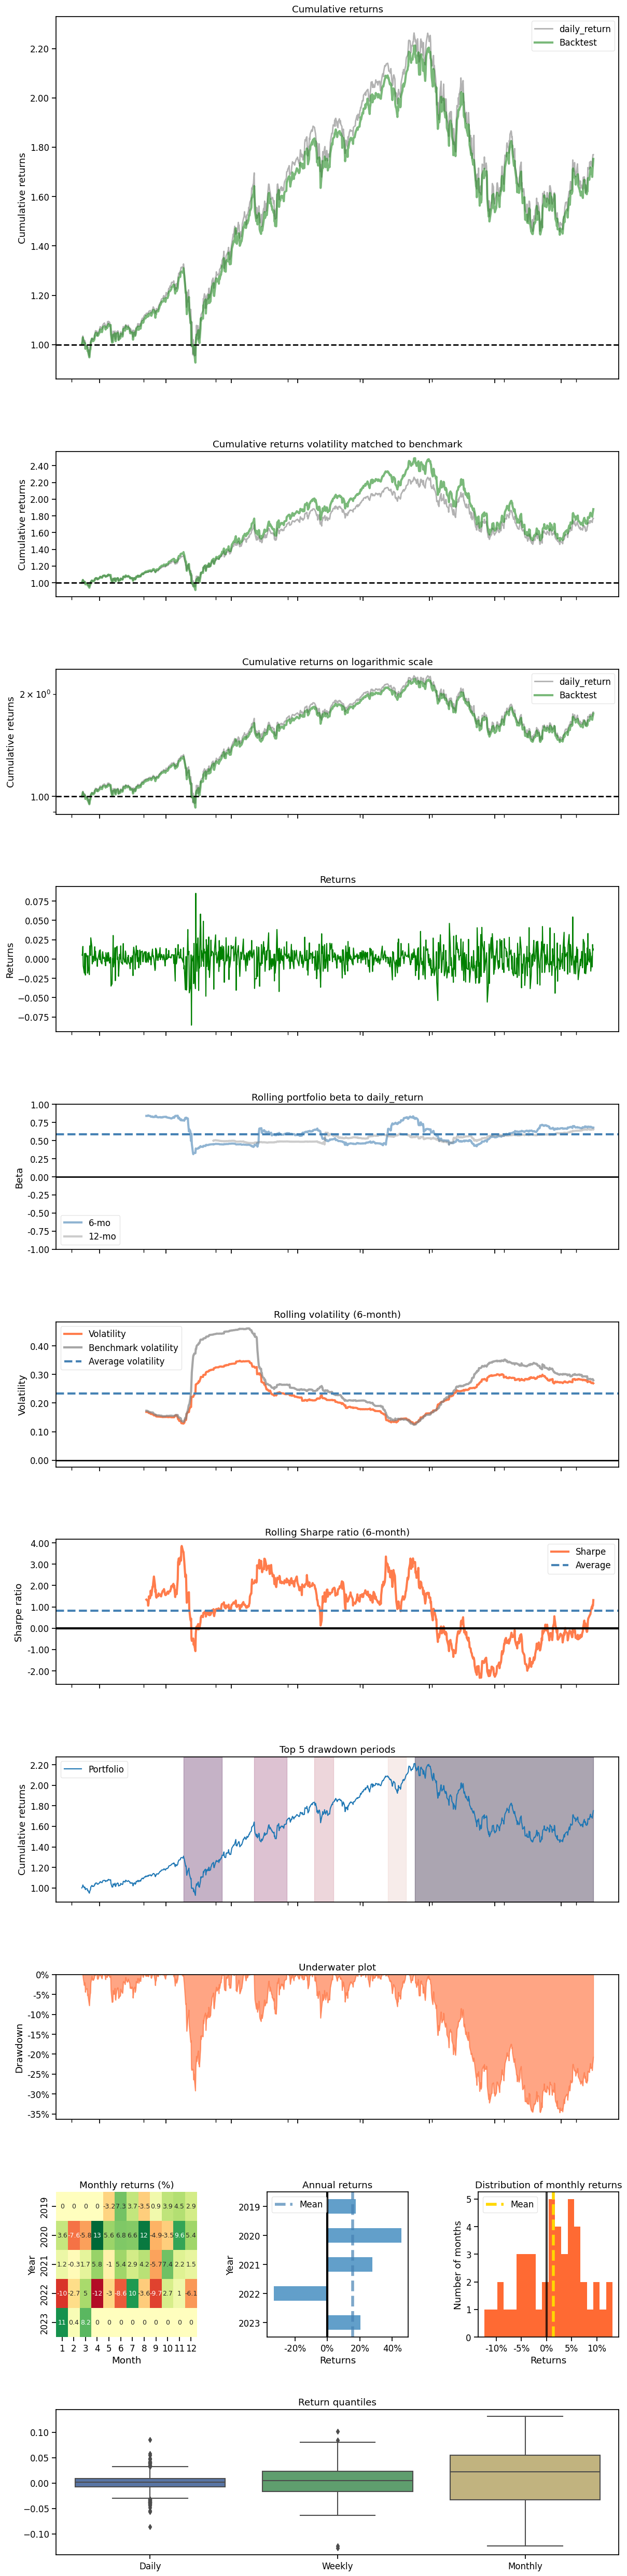

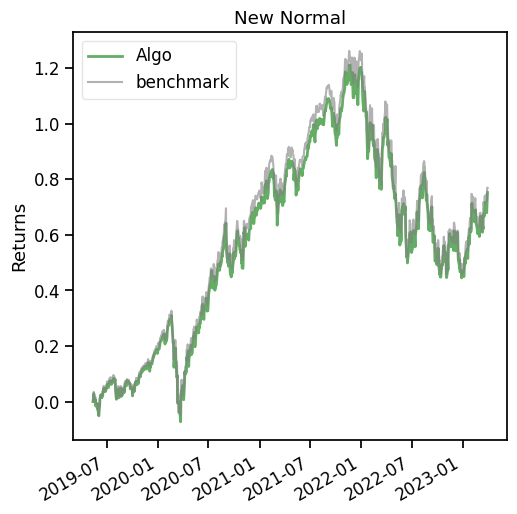

In [40]:
print("==============Compare to NDX===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(daily_NAV, 
             baseline_ticker = '^NDX', 
             baseline_start = daily_NAV.loc[0,'date'],
             baseline_end = daily_NAV.loc[len(daily_NAV)-1,'date'])